In [10]:
from IPython import display
import binascii
import os

def hide_code_in_slideshow():
    uid = binascii.hexlify(os.urandom(8)).decode()    
    html = """<div id="%s"></div>
    <script type="text/javascript">
        $(function(){
            var p = $("#%s");
            if (p.length==0) return;
            while (!p.hasClass("cell")) {
                p=p.parent();
                if (p.prop("tagName") =="body") return;
            }
            var cell = p;
            cell.find(".input").addClass("hide-in-slideshow")
        });
    </script>""" % (uid, uid)
    display.display_html(html, raw=True)

In [11]:
%%html
<style>
 .container.slides .celltoolbar, .container.slides .hide-in-slideshow {
    display: None ! important;
}
</style>

# Real or Not? NLP with Disaster Tweets
Christopher Akiki, Karl-Heinz Fiebig, Julian Duwe

Supervized by Christian Kahmann

## Overview

* Introduction: Task and Data

* Frameworks: cookiecutter hierarchy + docker + makefile + jupyter + tensorflow + scikitlearn + others

* Exploratory Data Analysis

* Preprocessing: BoW etc. - Julian

* Metafeatures - KH

* Representation Learning / Topic Modeling / Sentiment Analysis - Chris

* Outlook: Ensemble Learning (Stacking) etc.

* We used bla

* We won all of Kaggle
![](https://upload.wikimedia.org/wikipedia/commons/7/7c/Kaggle_logo.png)

# Meta-Level Features
* Tweet Statisitcs
* Lingustic Tags
* Named Entities
* Acronyms & Emojis
* Word Emphasis & Punctuation
* Sentiment Scores

In [27]:
# Run some preprocessing used throughout the rest of the sections

!pip install textblob vaderSentiment afinn

import pandas as pd
import numpy as np
import spacy
import matplotlib.pyplot as plt
from sklearn import preprocessing, feature_extraction, feature_selection
from features import meta_features_spacy as mf

# The training data file
train_data_file = '../data/external/kaggle/train.csv'
# Load data and perform some sanity checks
print('Loading training data from {}...'.format(train_data_file))
df = pd.read_csv(train_data_file)
X = df[['keyword', 'location', 'text']].values
y = df['target'].values
print('-> Done')

# Perform basic preprocessing of the data and convert to a spacy featuer set
sp = spacy.load('en_core_web_sm')
def preproc(x):
    txt = " ".join([str(x[i]) for i in range(0, 3) if str(x[i]) != "nan"])
    return sp(txt)
print("Converting tweets to spacy docs...")
X_sp = np.array([preproc(x) for x in X], dtype=object)
print("-> Done.")

# Define some functions that will be used throughout the slides
# Bar plot function to visualise the tag distributions
def plot_count_vec_bars(X_sp, transformer, title, exclude=[]):  
    transformer.fit(X_sp)
    labels = transformer.get_feature_names()
    
    # Compute counts
    count = transformer.transform(X_sp).toarray()
    # Remove blacklisted tags from column
    for exc_tag in exclude:
        del_idx = labels.index(exc_tag.lower())
        labels = np.delete(labels, del_idx)
        count = np.delete(count, del_idx, 1)
        
    # Compute support: how many of the tweets have non zero rows out of all tweets
    support = np.sum(np.sum(count, axis=1) > 0) / float(len(y))

    # Split counts into classes
    count_c0 = count[y==0]
    count_c1 = count[y==1]
    s0 = count_c0.sum(axis=0)
    s1 = count_c1.sum(axis=0)

    # Sort by class 0 counts
    sorted_idx = np.argsort(s0)[::-1]
    s0 = s0[sorted_idx]
    s1 = s1[sorted_idx]
    labels = np.array(labels)[sorted_idx]

    plt.title('{} (Support: {}%)'.format(title, round(support*100, 1)))
    plt.bar(np.arange(len(labels)), s0/float(s0.sum()), fc=(0, 0, 1, 0.5), label="Class 0")
    plt.bar(np.arange(len(labels)), s1/float(s1.sum()), fc=(1, 0, 0, 0.5), label="Class 1")
    plt.xticks(np.arange(len(labels)), labels, rotation=90)
    plt.legend()
    plt.xlabel("Tag")

Loading training data from ../data/external/kaggle/train.csv...
-> Done
Converting tweets to spacy docs...
-> Done.


## Features based on Tweet Statistics

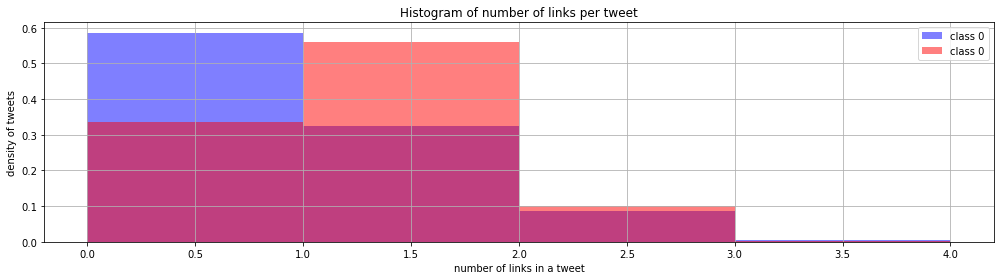

In [15]:
hide_code_in_slideshow()

# Plot link counters
trans = mf.LinkCounter()
counts_c0 = trans.transform(X_sp[y==0]).flatten()
counts_c1 = trans.transform(X_sp[y==1]).flatten()
# Plot a histogram of the number of tweets over link counts per tweet
plt.figure(figsize=(14, 4))
# Plot historgram for class 0
plt.title('Histogram of number of links per tweet')
bins = range(0, max(counts_c0)+1)
n, _, _ = plt.hist(counts_c0, bins, density=True, facecolor='b', label='class 0', alpha=0.5)
n, _, _ = plt.hist(counts_c1, bins, density=True, facecolor='r', label='class 0', alpha=0.5)
plt.xlabel('number of links in a tweet')
plt.ylabel('density of tweets')
plt.grid(True)
# Show final plots
plt.legend()
plt.tight_layout()
plt.show()


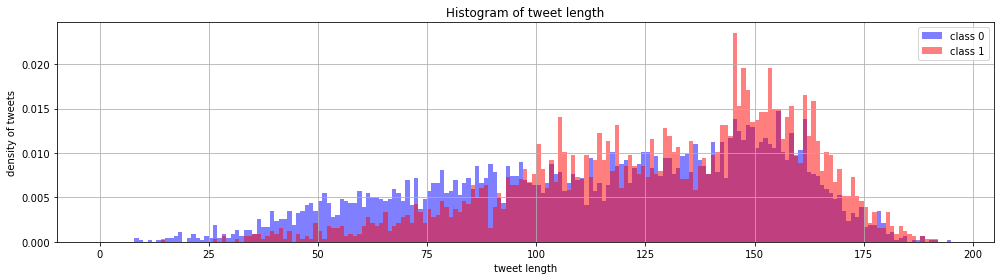

In [17]:
hide_code_in_slideshow()

# Count number of links in each tweet
trans = mf.TextLength()
counts_c0 = trans.transform(X_sp[y==0]).flatten()
counts_c1 = trans.transform(X_sp[y==1]).flatten()

# Plot a histogram of the number of tweets over link counts per tweet
plt.figure(figsize=(14, 4))
# Plot historgram for class 0
plt.title('Histogram of tweet length')
bins = range(0, max(counts_c0)+1)
n, _, _ = plt.hist(counts_c0, bins, density=True, facecolor='b', label='class 0', alpha=0.5)
n, _, _ = plt.hist(counts_c1, bins, density=True, facecolor='r', label='class 1', alpha=0.5)
plt.xlabel('tweet length')
plt.ylabel('density of tweets')
plt.grid(True)
# Show final plots
plt.legend()
plt.tight_layout()
plt.show()

## Features based on Linguistic Tags

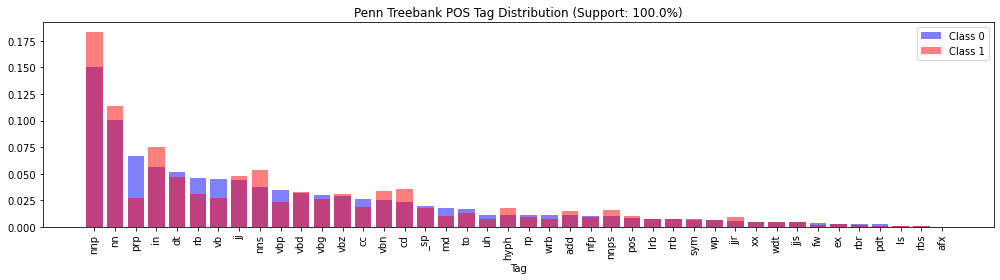

In [30]:
hide_code_in_slideshow()
plt.figure(figsize=(14, 4))
plot_count_vec_bars(X_sp, mf.PosTagCountVectorizer('penn_treebank'), 'Penn Treebank POS Tag Distribution')
plt.tight_layout()

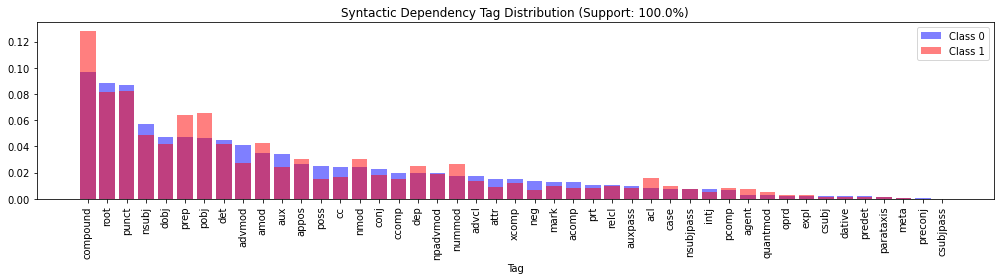

In [32]:
hide_code_in_slideshow()
plt.figure(figsize=(14, 4))
plot_count_vec_bars(X_sp, mf.DependencyTagCountVectorizer(), 'Syntactic Dependency Tag Distribution')
plt.tight_layout()

In [6]:
a = "This won't be shown"

In [7]:
"Abd".isnumeric()

False

Blablabla

In [8]:
1+1

2